In [1]:
import os

import numpy as np

from preprocess import Preprocessor
from data import data_loader, kfold_split
from models import get_classifier, optimize, retrain, retrain_whole
from evaluate import evaluate
from submission import submission
from config import args

from sklearn.metrics import accuracy_score

/home/jylee/miniconda3/envs/recommender/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-07-07 09:58:09.023801: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-07 09:58:09.219158: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-07 09:58:10.504592: W tensorflow/compiler/xla/stream_executor/

In [2]:
train_df = data_loader(args['train_path'], format='csv')
test_df = data_loader(args['test_path'], format='csv')

In [3]:
# split X, y
train_X = train_df.drop(columns=['id', 'EC1', 'EC2', 'EC3', 'EC4', 'EC5', 'EC6'])
train_y = train_df[['EC1', 'EC2']]#.astype('int32')
test_X = test_df.drop(columns=['id'])

In [4]:
train_X.columns

Index(['BertzCT', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3v', 'Chi4n',
       'EState_VSA1', 'EState_VSA2', 'ExactMolWt', 'FpDensityMorgan1',
       'FpDensityMorgan2', 'FpDensityMorgan3', 'HallKierAlpha',
       'HeavyAtomMolWt', 'Kappa3', 'MaxAbsEStateIndex', 'MinEStateIndex',
       'NumHeteroatoms', 'PEOE_VSA10', 'PEOE_VSA14', 'PEOE_VSA6', 'PEOE_VSA7',
       'PEOE_VSA8', 'SMR_VSA10', 'SMR_VSA5', 'SlogP_VSA3', 'VSA_EState9',
       'fr_COO', 'fr_COO2'],
      dtype='object')

In [7]:
from imblearn.over_sampling import SMOTE

# SMOTE 객체 생성
smote = SMOTE(k_neighbors=3, random_state=42, n_jobs=-1)
# 샘플링
X_train_resampled, y_train_resampled = smote.fit_resample(train_X, train_y)

ValueError: Imbalanced-learn currently supports binary, multiclass and binarized encoded multiclasss targets. Multilabel and multioutput targets are not supported.

In [19]:
from skmultilearn.problem_transform import LabelPowerset
from imblearn.over_sampling import RandomOverSampler

lp = LabelPowerset()
ros = RandomOverSampler(random_state=42)

# Applies the above stated multi-label (ML) to multi-class (MC) transformation.
yt = lp.transform(train_y)

X_resampled, y_resampled = ros.fit_resample(train_X, yt)

# Inverts the ML-MC transformation to recreate the ML set
y_resampled = lp.inverse_transform(y_resampled)

In [21]:
# Applies the above stated multi-label (ML) to multi-class (MC) transformation.
yt = lp.transform(train_y)

X_resampled, y_resampled = ros.fit_resample(train_X, yt)

# Inverts the ML-MC transformation to recreate the ML set
y_resampled = lp.inverse_transform(y_resampled)

In [24]:
y_resampled.toarray().shape

(30028, 2)

In [26]:
train_y.shape

(14838, 2)

In [27]:
train_y.value_counts()

EC1  EC2
1    1      7507
0    1      4348
1    0      2401
0    0       582
Name: count, dtype: int64

In [31]:
import pandas as pd
pd.DataFrame(y_resampled.toarray()).value_counts()

0  1
0  0    7507
   1    7507
1  0    7507
   1    7507
Name: count, dtype: int64

In [32]:
X_resampled

,BertzCT,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3v,Chi4n,EState_VSA1,EState_VSA2,...,PEOE_VSA14,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,SMR_VSA10,SMR_VSA5,SlogP_VSA3,VSA_EState9,fr_COO,fr_COO2
0,323.390782,9.879918,5.875576,5.875576,4.304757,4.304757,2.754513,1.749203,0.000000,11.938294,...,91.536492,0.000000,0.000000,0.000000,17.744066,0.000000,4.794537,35.527357,0,0
1,273.723798,7.259037,4.441467,5.834958,3.285046,4.485235,2.201375,1.289775,45.135471,0.000000,...,7.822697,0.000000,0.000000,0.000000,7.822697,30.705892,13.825658,44.707310,0,0
2,521.643822,10.911303,8.527859,11.050864,6.665291,9.519706,5.824822,1.770579,15.645394,6.606882,...,15.645394,0.000000,53.378235,0.000000,15.645394,73.143616,17.964475,45.660120,0,0
3,567.431166,12.453343,7.089119,12.833709,6.478023,10.978151,7.914542,3.067181,95.639554,0.000000,...,21.335138,0.000000,0.000000,6.420822,15.645394,62.107304,31.961948,87.509997,0,0
4,112.770735,4.414719,2.866236,2.866236,1.875634,1.875634,1.036450,0.727664,17.980451,12.841643,...,11.938611,6.923737,19.386400,0.000000,11.938611,18.883484,9.589074,33.333333,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30023,340.373175,10.756127,8.097512,8.097512,5.239190,5.239190,3.360526,2.331931,12.011146,13.027704,...,91.536492,45.448667,0.000000,0.000000,17.659730,109.023173,9.589074,43.210838,1,1
30024,277.172776,7.221033,4.299605,5.829902,3.323218,4.562571,2.579512,1.239132,45.135471,0.000000,...,7.822697,0.000000,0.000000,0.000000,7.822697,30.705892,13.825658,44.554682,0,0
30025,213.204130,4.877010,2.862978,2.862978,1.985258,1.985258,0.946055,0.358701,0.000000,6.420822,...,0.000000,0.000000,12.999757,23.520590,5.687386,18.628754,4.794537,27.000000,0,0
30026,207.557662,4.091423,2.680433,2.680433,1.975621,1.975621,1.018939,0.592466,12.011146,5.563451,...,5.969305,0.000000,18.199101,0.000000,5.969305,0.000000,4.794537,39.166667,1,1


In [5]:
# preprocess fit, transform
preprocessor = Preprocessor(train_X, args['dataname'])
train_X = preprocessor.transform(train_X)
test_X = preprocessor.transform(test_X)

/home/jylee/miniconda3/envs/recommender/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jylee/miniconda3/envs/recommender/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


(14838, 47)


/home/jylee/miniconda3/envs/recommender/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


(9893, 47)


array([[<Axes: title={'center': 'BertzCT'}>,
        <Axes: title={'center': 'Chi1'}>,
        <Axes: title={'center': 'Chi1n'}>,
        <Axes: title={'center': 'Chi1v'}>,
        <Axes: title={'center': 'Chi2n'}>,
        <Axes: title={'center': 'Chi2v'}>,
        <Axes: title={'center': 'Chi3v'}>],
       [<Axes: title={'center': 'Chi4n'}>,
        <Axes: title={'center': 'EState_VSA1'}>,
        <Axes: title={'center': 'EState_VSA2'}>,
        <Axes: title={'center': 'ExactMolWt'}>,
        <Axes: title={'center': 'FpDensityMorgan1'}>,
        <Axes: title={'center': 'FpDensityMorgan2'}>,
        <Axes: title={'center': 'FpDensityMorgan3'}>],
       [<Axes: title={'center': 'HallKierAlpha'}>,
        <Axes: title={'center': 'HeavyAtomMolWt'}>,
        <Axes: title={'center': 'Kappa3'}>,
        <Axes: title={'center': 'MaxAbsEStateIndex'}>,
        <Axes: title={'center': 'MinEStateIndex'}>,
        <Axes: title={'center': 'NumHeteroatoms'}>,
        <Axes: title={'center': 'PEOE_V

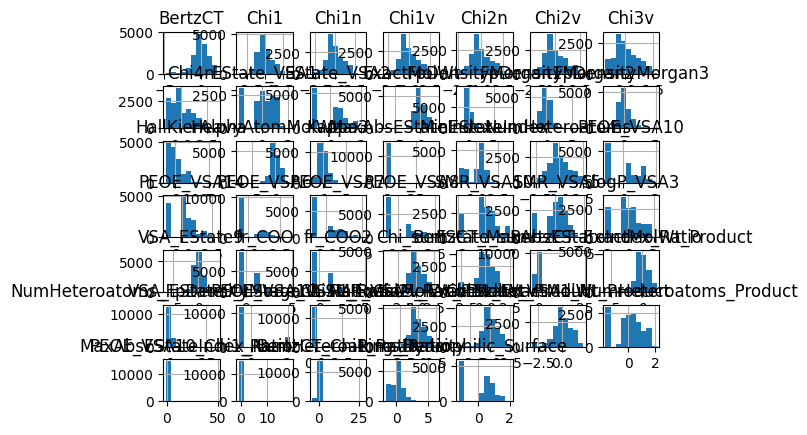

In [6]:
train_X.hist()

In [7]:
# split data with CV
data_splited = kfold_split(
    train_X, train_y, args['dataname'], n_splits=10)

In [8]:
best_params = optimize(
        'xgboost',
        args['task'],
        train_X, train_y
    )

[I 2023-07-06 20:16:39,346] A new study created in memory with name: no-name-27ee6374-4406-441a-a568-a0405af6d7a1
/home/jylee/miniconda3/envs/recommender/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 500] and step=100, but the range is not divisible by `step`. It will be replaced by [50, 450].
  warnings.warn(
/home/jylee/miniconda3/envs/recommender/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [4, 110] and step=10, but the range is not divisible by `step`. It will be replaced by [4, 104].
  warnings.warn(
[I 2023-07-06 20:16:42,797] Trial 0 finished with value: 0.640531372713154 and parameters: {'n_estimators': 50, 'max_depth': 74, 'min_child_weight': 4.0, 'learning_rate': 0.010775191266011692, 'subsample': 0.5256870082972007, 'colsample_bytree': 0.7234733152221142, 'colsample_bynode': 0.5629496643393292, 'colsample_bylevel': 0.580087086165662, 'gamma': 0.0009080466

In [9]:
best_params

{'n_estimators': 450,
 'max_depth': 4,
 'min_child_weight': 6.0,
 'learning_rate': 0.0020978601085610673,
 'subsample': 0.6359977488409174,
 'colsample_bytree': 0.5035413144782546,
 'colsample_bynode': 0.8983377996965043,
 'colsample_bylevel': 0.5070283394533074,
 'gamma': 0.00010674440941514829,
 'reg_alpha': 0.4121244798926527,
 'reg_lambda': 0.18552294940745695}

In [10]:
# retrain and get preds
pred_array, train_metric = retrain(
    'xgboost',
    best_params,
    args['task'],
    data_splited,
    test_X
)

train auc:  0.5665361274796623
val auc:  0.5648070095556882
0.5665361274796623
train auc:  0.5686049268816142
val auc:  0.5534343621972488
0.5686049268816142
train auc:  0.568030207498184
val auc:  0.5656239137990963
0.568030207498184
train auc:  0.5699334368267207
val auc:  0.5632669135673674
0.5699334368267207
train auc:  0.5685359743017575
val auc:  0.5562123001537161
0.5685359743017575
train auc:  0.5660223168481257
val auc:  0.5696627549509248
0.5660223168481257
train auc:  0.5691735938720983
val auc:  0.5664107406375447
0.5691735938720983
train auc:  0.5678593536959936
val auc:  0.5613534367372648
0.5678593536959936
train auc:  0.566836112495883
val auc:  0.5623066248066249
0.566836112495883
train auc:  0.5671371385406719
val auc:  0.5623738619314795
0.5671371385406719


In [11]:
pred_array, train_metric = retrain_whole('xgboost', best_params, 'classification', train_X, train_y, test_X)

train auc:  0.5682202838118806
0.5682202838118806


In [12]:

#    if '+' in args['modelname']:
test_preds, train_metrics = [], []
for modelname in args['modelname'].split('+'):
    # get best parameters with optuna
    best_params = optimize(
        modelname,
#                args['modelname'],
        args['task'],
        train_X, train_y
    )
    # retrain and get preds
    pred_array, train_metric = retrain(
        modelname,
#                args['modelname'],
        best_params,
        args['task'],
        data_splited,
        test_X
    )

    if args['task'] == 'classification':
        test_pred = np.mean(pred_array, axis=0)
        train_metric = np.mean(train_metric, axis=0)
    
    test_preds.append(test_pred)
    train_metrics.append(train_metric)


[I 2023-07-06 20:24:24,579] A new study created in memory with name: no-name-a9b3ef31-8a68-4b95-8672-599481a7b8cf
/home/jylee/miniconda3/envs/recommender/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 500] and step=100, but the range is not divisible by `step`. It will be replaced by [50, 450].
  warnings.warn(
[I 2023-07-06 20:24:26,501] Trial 0 finished with value: 0.6212311348136138 and parameters: {'boosting_type': 'gbdt', 'n_estimators': 250, 'max_depth': 6, 'min_child_samples': 26, 'learning_rate': 0.08118811823101356, 'subsample': 0.6923538371972076, 'colsample_bytree': 0.8402236819253297, 'colsample_bynode': 0.9599384295262162, 'reg_alpha': 0.831598401791475, 'reg_lambda': 0.2176195465142524}. Best is trial 0 with value: 0.6212311348136138.
/home/jylee/miniconda3/envs/recommender/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 500] and step=100, but the ran

KeyboardInterrupt: 

In [ ]:
if len(test_pred) > 1:
    test_pred = np.mean(test_preds, axis=0)
    train_metric = np.mean(train_metrics, axis=0)

# submission
submission_df = data_loader(args['submission_path'], format='csv')
submission(test_pred, submission_df, args['modelname'],
    train_metrics=f'{train_metric:.4f}')

# data augmentation!!!